# Numerical Exercises 08

## Exercise 10.1

Starting from your Genetic Algorithm code implement a Parallel Tempering algorithm (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and add a trial move that proposes an exchange of paths among adjacent temperatures (nodes) (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

## Solution

### Parallel Tempering Algorithm

The Parallel Tempering algorithm is an evolution of the Simulated Annealing algorithm, where mutliple replicas of the system are simulated at different temperatures, allowing for better exploration of the solution space. At a given time step, replicas can exchange states based on the probability:

$$ P_{ij} = \min\left(1, \exp\left(-(\beta_i- \beta_j)(E_i - E_j)\right)\right) $$

where $E_i$ and $E_j$ are the energies of the states at temperatures $\beta_i$ and $\beta_j$, respectively. This swapping mechanism enables the algorithm to overcome high energy barriers and explore the solution space more effectively. 

For the TSP problem, states are represented by paths, and energy corresponds to the fitness used previously. Movement within the parameter space is achieved via random genetic mutations.

### Code

The main loop of the Parallel Tempering is very similar to the one i used in the Simulated Annealing algorithm 

```c++
/* ... */

// Parallel Tempering loop
for (int step = 1; step <= SA_steps; ++step) {
    // Simulated Annealing step
    trip trial = current;
    double r = rnd.Rannyu();
    if (r < 0.35) {
        trial.pair_permutation(rnd);
    } else if (r < 0.6) {
        int m = rnd.Rannyu(1, n_cities - 2);
        int n = rnd.Rannyu(1, n_cities - 2);
        trial.shift_mutation(rnd, m, n);
    } else if (r < 0.9) {
        int m = rnd.Rannyu(1, n_cities/2 - 1);
        trial.m_permutation(rnd, m);
    } else {
        trial.inversion();
    }
    trial.check();

    // acceptance criterion
    double f_trial = trial.distance();
    double p_acc = min(1.0, exp(-beta[rank] * (f_trial - f_current)));
    if (rnd.Rannyu() < p_acc) {
        current = trial;
        f_current = f_trial;
        if (f_current < f_best) {
            f_best = f_current;
            best = current;
        }
    }
        /* ... */
}

```

Then, every 1000 steps the algorithm will try to swap the states of the replicas. I used an even-odd strategy to swap the states of the replicas, where even ranks will try to swap with the next odd rank.


```c++

/* ... */

if (step % 1000 == 0) {
    int partner = -1;
    // partner selection 
    // use a even-odd pattern to avoid deadlocks
    if (((step/500) % 2) == 0) {
        // if rank is even, partner is next rank, if odd, partner is previous rank
        if (rank % 2 == 0 && rank < size - 1) partner = rank + 1;
        else if (rank % 2 == 1) partner = rank - 1;
    } else {
        if (rank % 2 == 1 && rank < size - 1) partner = rank + 1;
        else if (rank % 2 == 0 && rank > 0) partner = rank - 1;
    }
    
    /* ... */
}

```

This strategy ensures that no process is left waiting indefinitely for a partner to swap with, thus avoiding deadlocks. The swap part is implemented with MPI_Isend and MPI_Irecv, which allows for non-blocking communication between processes.

```c++
/* ... */

// Ensure partner is within bounds
if (partner >= 0 && partner < size) {
    // fitness exchange
    double send_f = f_current, recv_f;
    MPI_Request reqs[2]; // Isend and Irecv are non-blocking so we need requests
    MPI_Isend(&send_f, 1, MPI_DOUBLE, partner, 0, MPI_COMM_WORLD, &reqs[0]);
    MPI_Irecv(&recv_f, 1, MPI_DOUBLE, partner, 0, MPI_COMM_WORLD, &reqs[1]);
    MPI_Waitall(2, reqs, MPI_STATUSES_IGNORE); // wait for both sends and receives

    // swap probability calculation
    double delta = (beta[partner] - beta[rank]) * (recv_f - f_current);
    double p_swap = min(1.0, exp(delta));
    int do_swap = (rnd.Rannyu() < p_swap) ? 1 : 0;
    int partner_swap;

    // Sendrecv avoids deadlocks by sending and receiving in one call
    MPI_Sendrecv(&do_swap, 1, MPI_INT, partner, 1,
         &partner_swap, 1, MPI_INT, partner, 1,
         MPI_COMM_WORLD, MPI_STATUS_IGNORE);

    // if swap is accepted, exchange paths
    if (do_swap && partner_swap) {
        vector<int> send_path = current.get_path();
        vector<int> recv_path(n_cities);
        MPI_Request reqs2[2];
        MPI_Isend(send_path.data(), n_cities, MPI_INT, partner, 2, MPI_COMM_WORLD, &reqs2[0]);
        MPI_Irecv(recv_path.data(), n_cities, MPI_INT, partner, 2, MPI_COMM_WORLD, &reqs2[1]);
        MPI_Waitall(2, reqs2, MPI_STATUSES_IGNORE);

        current.set_path(recv_path);
        f_current = recv_f;
        if (f_current < f_best) {
        f_best = f_current;
        best = current;
        }
    }
}

/* ... */
```

At the end of the algorithm, the best path is shared among all processes using `MPI_Allreduce` to find the global best path across all replicas. 

```c++

/* ... */
// Find the best path across all ranks
struct {
    double value;
    int rank;
} local, global;
local.value = f_best;
local.rank = rank;
MPI_Allreduce(&local, &global, 1, MPI_DOUBLE_INT, MPI_MINLOC, MPI_COMM_WORLD);

vector<int> global_path(n_cities);
if (rank == global.rank) {
        global_path = best.get_path();
}
// Broadcast the best path to all ranks
MPI_Bcast(global_path.data(), n_cities, MPI_INT, global.rank, MPI_COMM_WORLD);

/* ... */
```

The best path is expected to be found on the node with the lowest temperature, so this part of the code is useful when there are many processes running at similar temperatures.

## Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Solution

I ran my program on a remote lab computer with 12 nodes for the Parallel Tempering algorithm, the temperature range was set from 5 to 0.01 with a logarithmic scale

```c++
double T_max = 5.0;
double T_min = 0.01;
double log_Tmax = log(T_max);
double log_Tmin = log(T_min);
for (int i = 0; i < size; ++i) {
    temp[i] = exp(log_Tmax - (log_Tmax - log_Tmin) * i / (size - 1));
    beta[i] = 1.0 / temp[i];
}
```

For a "fair" comparison with the serial Genetic Algorithm, i used the 12 individuals for the population number, with the same parameters as the previous exercise in terms of mutation and crossover probabilities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'

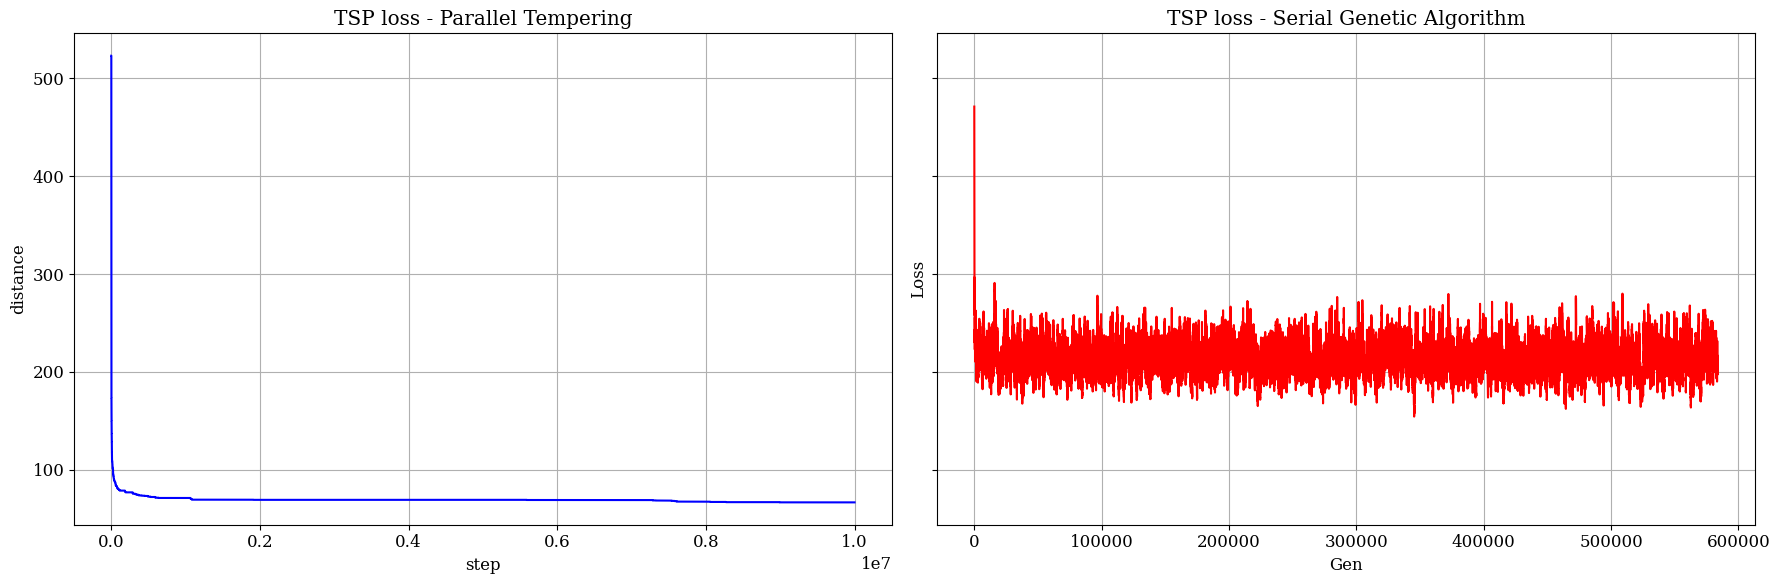

Min Loss parallel tempering: 66.5485
Min Loss Genetic: 154.263


In [2]:
pt_loss = pd.read_csv('datatolab/parallel_tempering.dat', sep = " ")
serial_genetic_loss = pd.read_csv('datatolab/best_loss_genetic.dat', sep=" ")

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

axs[0].plot(pt_loss['step'], pt_loss['fitness'], color='blue')
axs[0].set_xlabel('step')
axs[0].set_ylabel('distance')
axs[0].set_title('TSP loss - Parallel Tempering')
axs[0].grid()

axs[1].plot(serial_genetic_loss['Generation'], serial_genetic_loss['Loss'], color='red')
axs[1].set_xlabel('Gen')
axs[1].set_ylabel('Loss')
axs[1].set_title('TSP loss - Serial Genetic Algorithm')
axs[1].grid()

plt.tight_layout()
plt.show()

print('Min Loss parallel tempering:', pt_loss['fitness'].min())
print('Min Loss Genetic:', serial_genetic_loss['Loss'].min())

As we can see from the plots above, the Parallel Tempering algorithm performs significantly better than the serial Genetic Algorithm which doesn't converge. The power of the Genetic Algorithm lies in its population diversity, which enables a more thorough exploration of the solution space. To achieve similar performance with the Genetic Algorithm, we would need to increase its population size like in the previous exercise.

The purpose of this comparison isn't to criticize the Genetic Algorithm, but to illustrate the computational efficiency of the Parallel Tempering algorithm.

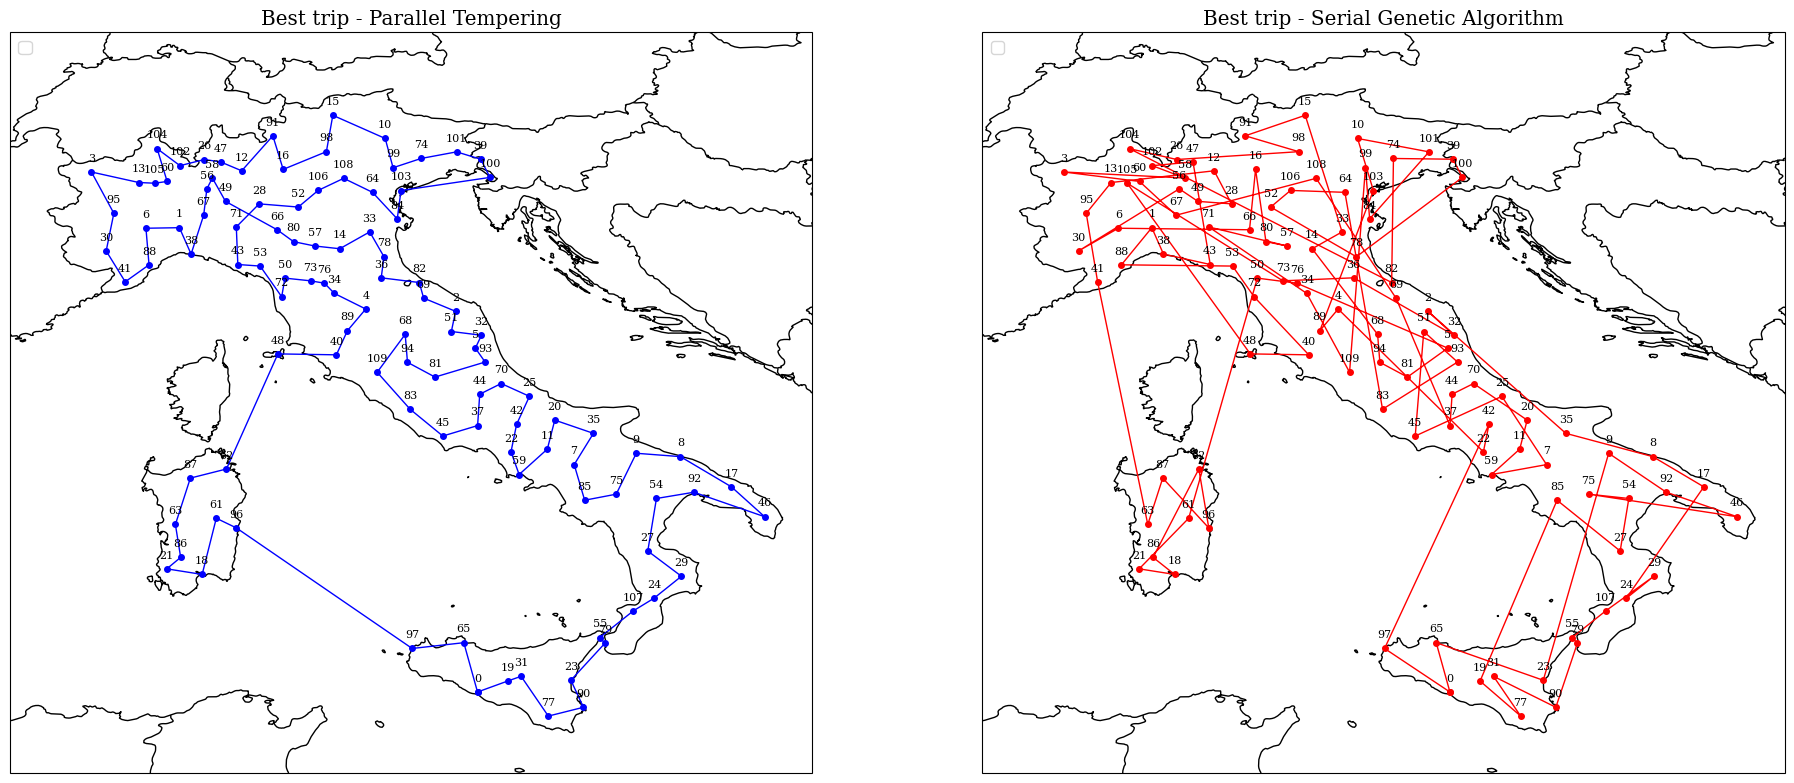

Min Loss Parallel Tempering: 66.5485
Min Loss Genetic: 154.263


In [3]:
# Load the data
italian_cities = pd.read_csv('cap_prov_ita.dat', sep=" ", header=None)
best_trip_pt = pd.read_csv('datatolab/parallel_tempering_best_path.dat', sep = " ", skiprows=1, header=None)
trip_indices_pt = best_trip_pt.iloc[0].dropna().astype(int).values
trip_coords_pt = italian_cities.iloc[trip_indices_pt][[0, 1]].values
trip_coords_pt = np.vstack([trip_coords_pt, trip_coords_pt[0]])


best_trip_genetic = pd.read_csv('datatolab/best_trip_genetic.dat', sep=" ", skiprows=1, header=None)
idx_best = best_trip_genetic[1].idxmin()
best_row = best_trip_genetic.iloc[idx_best]
trip_indices_gen = best_row.dropna().iloc[2:].astype(int).values
trip_coords_gen = italian_cities.iloc[trip_indices_gen][[0, 1]].values
trip_coords_gen = np.vstack([trip_coords_gen, trip_coords_gen[0]])

fig, axs = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Parallel Tempering plot
axs[0].set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())
axs[0].add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black')
axs[0].add_feature(cfeature.COASTLINE.with_scale('10m'))
axs[0].plot(trip_coords_pt[:, 0], trip_coords_pt[:, 1], '-o',
            color='blue', markersize=4, transform=ccrs.PlateCarree(), lw=1.)
for i, (x, y) in italian_cities[[0, 1]].iterrows():
    axs[0].text(x, y + 0.15, str(i), fontsize=8, ha='center', va='bottom', color='black')
axs[0].set_title('Best trip - Parallel Tempering')
axs[0].legend(loc='upper left')

# Serial Genetic Algorithm plot (min loss)
axs[1].set_extent([6, 19, 36, 48], crs=ccrs.PlateCarree())
axs[1].add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black')
axs[1].add_feature(cfeature.COASTLINE.with_scale('10m'))
axs[1].plot(trip_coords_gen[:, 0], trip_coords_gen[:, 1], '-o',
            color='red', markersize=4, transform=ccrs.PlateCarree(), lw=1.)
for i, (x, y) in italian_cities[[0, 1]].iterrows():
    axs[1].text(x, y + 0.15, str(i), fontsize=8, ha='center', va='bottom', color='black')
axs[1].set_title('Best trip - Serial Genetic Algorithm')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print('Min Loss Parallel Tempering:', pt_loss['fitness'].min())
print('Min Loss Genetic:', serial_genetic_loss['Loss'].min())